In [157]:
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import numpy as np

from tensorflow.keras import layers

AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = 160
BATCH_SIZE = 128
class_names=["gato","perro"]

In [109]:

TRAINING_FILENAMES = tf.io.gfile.glob("TFrecords_DS/train/*.tfrecords")
VALID_FILENAMES = tf.io.gfile.glob("TFrecords_DS/validation/*.tfrecords")

print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))


Train TFRecord Files: 63
Validation TFRecord Files: 32


In [110]:
import scipy.ndimage as ndimage

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

def random_rotate_image(image):
    image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
    return image

def tf_random_rotate_image(image, label):
    im_shape = image.shape
    [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label

def augment(image,label):
    #image, label = resize_and_rescale(image, label)
    # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, IMAGE_SIZE + 6, IMAGE_SIZE + 6) 
    # Random crop back to the original size
    image = tf.image.random_crop(image, size=[IMAGE_SIZE, IMAGE_SIZE, 3])
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    #image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
    #image = tf.clip_by_value(image, 0, 1)
    return image, label

In [111]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    #image = tf.reshape(image, [*IMAGE_SIZE, 3])
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
   
    return image

In [112]:
def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
            'label': tf.io.FixedLenFeature([], tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
        }
        if labeled
        else {"image_raw": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image_raw"])
    if labeled:
        label = tf.cast(example["label"], tf.int32)
        return image, label
    return image

In [113]:
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

In [114]:
def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.cache()
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(augment, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(tf_random_rotate_image,num_parallel_calls=AUTOTUNE)
    #dataset = dataset.map(lambda x, y: (data_augmentation(tf.expand_dims(x, 0)), y), 
    #            num_parallel_calls=AUTOTUNE)
    #dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset.prefetch(buffer_size=AUTOTUNE)

In [115]:
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)

In [116]:
image_batch, label_batch = next(iter(train_dataset))
print(image_batch.shape)
print(label_batch.shape)

(128, 160, 160, 3)
(128,)


In [117]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        img=image_batch[n] 
      
        #print(img.shape)
        plt.imshow(img/255)
        if label_batch[n]:
            plt.title("dog")
        else:
            plt.title("cat")
        plt.axis("off")

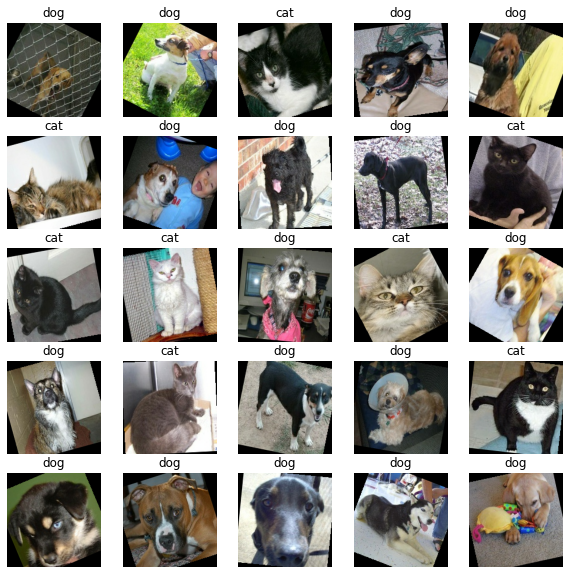

In [118]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [119]:
# Create the base model from the pre-trained model MobileNet V2


IMG_SHAPE = (IMAGE_SIZE,IMAGE_SIZE) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [120]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 5, 5, 1280)


In [121]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [122]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(128, 1280)


In [123]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(128, 1)


In [124]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [125]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [126]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0   

In [127]:
len(model.trainable_variables)

2

In [133]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(valid_dataset)

8/8 [==============================] - 2s 173ms/step - loss: 0.3307 - accuracy: 0.8828


In [134]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.33
initial accuracy: 0.88


In [138]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=valid_dataset)

Epoch 1/30
16/16 [==============================] - 6s 316ms/step - loss: 0.3861 - accuracy: 0.8061 - val_loss: 0.2203 - val_accuracy: 0.9180
Epoch 2/30
16/16 [==============================] - 6s 314ms/step - loss: 0.3703 - accuracy: 0.8165 - val_loss: 0.2111 - val_accuracy: 0.9248
Epoch 3/30
16/16 [==============================] - 6s 311ms/step - loss: 0.3728 - accuracy: 0.8155 - val_loss: 0.2107 - val_accuracy: 0.9238
Epoch 4/30
16/16 [==============================] - 5s 254ms/step - loss: 0.3526 - accuracy: 0.8299 - val_loss: 0.2080 - val_accuracy: 0.9248
Epoch 5/30
16/16 [==============================] - 6s 310ms/step - loss: 0.3679 - accuracy: 0.8264 - val_loss: 0.1933 - val_accuracy: 0.9346
Epoch 6/30
16/16 [==============================] - 5s 291ms/step - loss: 0.3577 - accuracy: 0.8209 - val_loss: 0.1872 - val_accuracy: 0.9463
Epoch 7/30
16/16 [==============================] - 5s 270ms/step - loss: 0.3471 - accuracy: 0.8353 - val_loss: 0.1900 - val_accuracy: 0.9316
Epoch 

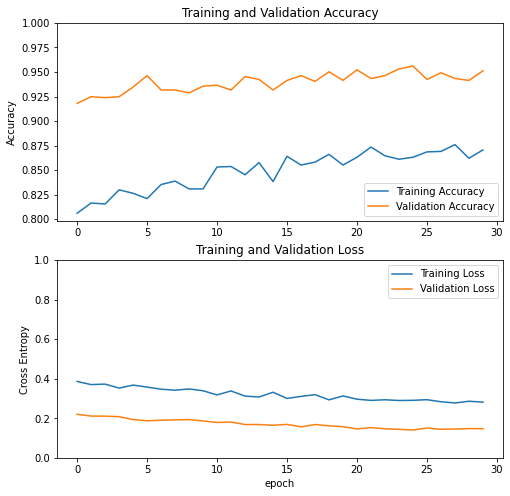

In [139]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [140]:
base_model.trainable = True

In [141]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [143]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


In [145]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [146]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0   

In [147]:
len(model.trainable_variables)

56

In [149]:
fine_tune_epochs = 10
total_epochs =  30 + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_dataset)

Epoch 30/40
16/16 [==============================] - 9s 334ms/step - loss: 0.2961 - accuracy: 0.8714 - val_loss: 0.1001 - val_accuracy: 0.9688
Epoch 31/40
16/16 [==============================] - 6s 305ms/step - loss: 0.2250 - accuracy: 0.9034 - val_loss: 0.0993 - val_accuracy: 0.9629
Epoch 32/40
16/16 [==============================] - 6s 308ms/step - loss: 0.2165 - accuracy: 0.8982 - val_loss: 0.0964 - val_accuracy: 0.9590
Epoch 33/40
16/16 [==============================] - 6s 305ms/step - loss: 0.2256 - accuracy: 0.8928 - val_loss: 0.0980 - val_accuracy: 0.9707
Epoch 34/40
16/16 [==============================] - 6s 308ms/step - loss: 0.1871 - accuracy: 0.9214 - val_loss: 0.0974 - val_accuracy: 0.9678
Epoch 35/40
16/16 [==============================] - 6s 308ms/step - loss: 0.1862 - accuracy: 0.9251 - val_loss: 0.0869 - val_accuracy: 0.9619
Epoch 36/40
16/16 [==============================] - 6s 309ms/step - loss: 0.2116 - accuracy: 0.9127 - val_loss: 0.0861 - val_accuracy: 0.9775

In [150]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

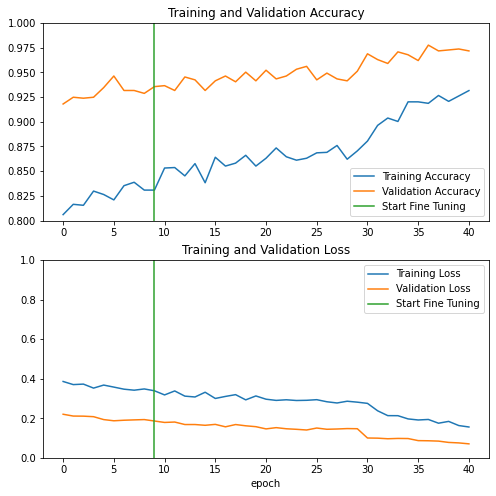

In [151]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [154]:
loss, accuracy = model.evaluate(train_dataset)
print('Test accuracy :', accuracy)

16/16 [==============================] - 4s 162ms/step - loss: 0.0667 - accuracy: 0.9752
Test accuracy : 0.9751983880996704


Predictions:
 [1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 1 1
 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1
 1 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0
 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0]
Labels:
 [1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 1 1
 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1
 1 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0
 1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0]


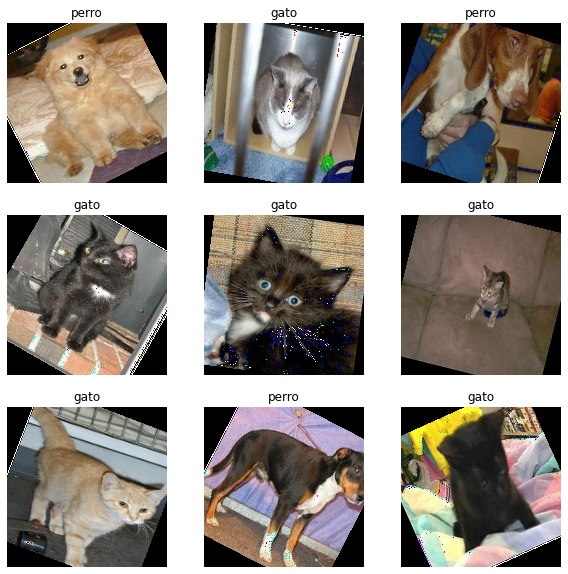

In [158]:
#Retrieve a batch of images from the test set
image_batch, label_batch = train_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")